# Image Editing with Diffusion Models
---
## Authors:
*   *Luca Conti* (1702084)
*   *Daniele sabatini* (1890300)
---
## Project aim and selected paper
This project is based on the implementation of the paper [*InstructPix2Pix: Learning to Follow Image Editing Instructions*](https://arxiv.org/abs/2211.09800).  

Our implementation is divided into three main parts:

1. *Fine-tuning LLM*  
   In the first part, we fine-tuned a LLM model to create a dataset containing original prompts, edit prompt and edited prompts thaht would later be used for the second component of the project.

2. *Image Generation with Stable Diffusion and ControlNet*  
   In the second part, we used the prompts generated in the first part to create pairs of images, where one was the edited version of the other (i.e., maintaining coherence between them).  
   For this, we employed *Stable Diffusion* together with *ControlNet*.  
   The generated images were then used to build the dataset required for the final part of the project.

3. *Fine-tuning InstructPix2Pix*  
   In the last part of the project, we used the dataset produced in the second part to fine-tune a Stable Diffusion model.


---

## Theoretical background and key concepts

**Fine-tuning** is the process of taking a pre-trained model (a model that has already been trained on a large and general dataset) and adapting it to a new, often more specific task or domain.  
Instead of training a model from scratch, which requires a huge amount of data and computational resources, fine-tuning allows us to leverage the *knowledge* already learned by the base model.

During fine-tuning, the model parameters are adjusted (either partially or completely) on a new dataset that is usually smaller and task-specific. This process helps the model specialize in the new task while retaining the general capabilities it learned during its initial training.
Fine-tuning provides several key advantages:

- **Data efficiency**: We do not need massive datasets, since the model already contains general knowledge.  
- **Reduced training time**: Adapting an existing model is much faster than training one from scratch.   
- **Domain adaptation**: It allows adapting a general-purpose model (e.g., trained on large text or image datasets) to a specialized domain.  

---

## Implementation details

This notebook implements the first stage of the project.  
It contains the code for fine-tuning the [**Gemma 2B**](https://huggingface.co/google/gemma-2b) model to generate an **`edit_prompt`** and an **`edited_prompt`** given an **`original_prompt`**.

For fine-tuning, we built a dataset of **800 samples**:

- **400 manually created samples**:  Starting from the `original_prompt` in the `TEXT` column of the [**laion/aesthetics_v2_4.75**](https://huggingface.co/datasets/laion/aesthetics_v2_4.75) dataset, we manually designed both the `edit_prompt` and the `edited_prompt`.  

- **400 samples from existing data**:  
  Taken directly from the [**InstructPix2Pix training dataset**](https://huggingface.co/datasets/timbrooks/instructpix2pix-clip-filtered), as used in the original paper.

Using the fine-tuned LLM, we then prepared the paired caption dataset for the second stage of the project:

- **2,900 samples** from [**visual-layer/imagenet-1k-vl-enriched**](https://huggingface.co/datasets/visual-layer/imagenet-1k-vl-enriched).  
  For each sample, the `original_prompt` was passed to the fine-tuned model, which generated the corresponding `edit_prompt` and `edited_prompt`.  

- **150 manually created samples**:  
  Added to further enrich the dataset.

---
## Limitations and reflections

The main limitations of the following code are related to computational resources and dataset size:

1. **Hardware constraints**:  
   Since the experiments were conducted on **Google Colab Pro**, which provides only **40 GB of A100 GPU memory**, it was not possible to fine-tune larger models such as **GEMMA 7B** or **GPT-3**(like in the original paper).  
   This restriction limited the scalability of our experiments and made the final dataset less precise compared to the one presented in the original paper.

2. **Dataset constraints**:  
   The dataset used for fine-tuning was **partially created manually**, which resulted in a relatively **small dataset size**.  
   This limitation affects the quality of the fine-tuning process, reducing the model’s ability to generalize effectively.
  
---
## References
*   Paper: [**InstructPix2Pix: Learning to Follow Image Editing Instructions**](https://arxiv.org/abs/2211.09800)
*  Model: [**Gemma 2B**](https://huggingface.co/google/gemma-2b)
*  Dataset for finetune: [**laion/aesthetics_v2_4.75**](https://huggingface.co/datasets/laion/aesthetics_v2_4.75)
*  Dataset for the second part: [**timbrooks/instructpix2pix-clip-filtered**](https://huggingface.co/datasets/timbrooks/instructpix2pix-clip-filtered)



# Import of library

In [ ]:
import time
import json
import numpy as np
from tqdm import tqdm
from transformers import pipeline
import random
import os
import gc
import pandas as pd
from pathlib import Path
from datasets import Dataset
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import login
# Add your hugging face token
login(token="...")

# Global variable


In [ ]:
DELIMITER_0 = "\n##\n"
DELIMITER_1 = "\n%%\n"
STOP = "\nEND"
# Add your hugging face token
HF_TOKEN = "..."

# Dataset for finetune of model
OTHER_DATASET_FINETUNE = "timbrooks/instructpix2pix-clip-filtered"
OUT_PATH_INSTRUCTPIX2PIX = "/content/drive/MyDrive/Neural Networks/PROJECT/MODEL/OUT_COLAB/FROM_GEMMA_2B/PROMPTS_FROM_INSTRUCTPIXTOPIX.jsonl"
DATASET_PATH_GOLDEN_FINETUNE_JSON = "/content/drive/MyDrive/Neural Networks/PROJECT/DATASET/dataset_finetune.json"
DATASET_PATH_GOLDEN_FINETUNE_JSONL = "/content/drive/MyDrive/Neural Networks/PROJECT/DATASET/dataset_finetune.jsonl"
FINAL_DATASET_FINETUNE_PATH = "/content/drive/MyDrive/Neural Networks/PROJECT/DATASET/DATASET_FINETUNE.jsonl"

# For finetune of model
SEED = 42
MODEL_ID_GEMMA2B = "google/gemma-2b"
OUT_PATH_GEMMA2B_FINETUNED = "/content/drive/MyDrive/Neural Networks/PROJECT/MODEL/FINETUNE_GEMMA_2B"

# Datset for ControlNet
SAVE_EVERY = 10
MAX_SAMPLES = 3000
DATASET_HF = "visual-layer/imagenet-1k-vl-enriched"
OUT_PATH_DATASET_HF = "/content/drive/MyDrive/Neural Networks/PROJECT/MODEL/OUT_COLAB/FROM_GEMMA_2B/FROM_HUGGING_FACE.json"
OUT_PATH_DATASET_GENERATED_JSONL = "/content/drive/MyDrive/Neural Networks/PROJECT/MODEL/OUT_COLAB/FROM_GEMMA_2B/triplets_generated.jsonl"
OUT_PATH_DATASET_GENERATED_CSV   = "/content/drive/MyDrive/Neural Networks/PROJECT/MODEL/OUT_COLAB/FROM_GEMMA_2B/triplets_generated.csv"
OUT_PATH_DATASET_GENERATED_JSONL_CLEANED = "/content/drive/MyDrive/Neural Networks/PROJECT/MODEL/OUT_COLAB/FROM_GEMMA_2B/triplets_generated_clean.jsonl"
OUT_PATH_FINAL_DATA = "/content/drive/MyDrive/Neural Networks/PROJECT/DATASET/DATASET_CONTROLNET_CLEAN.jsonl"
GOLDEN_SAMPLES_JSON = "/content/drive/MyDrive/Neural Networks/PROJECT/DATASET/golden_label.json"
GOLDEN_SAMPLES_JSONL = "/content/drive/MyDrive/Neural Networks/PROJECT/DATASET/golden_label.jsonl"

# For adding only 1000 samples
#OUT_PATH_DATASET_GENERATED_JSONL = "/content/drive/MyDrive/Neural Networks/PROJECT/MODEL/OUT_COLAB/FROM_GEMMA_2B/triplets_generated_from_1900_2900.jsonl"
#OUT_PATH_DATASET_GENERATED_CSV   = "/content/drive/MyDrive/Neural Networks/PROJECT/MODEL/OUT_COLAB/FROM_GEMMA_2B/triplets_generated_from_1900_2900.csv"
#OUT_PATH_DATASET_GENERATED_JSONL_CLEANED = "/content/drive/MyDrive/Neural Networks/PROJECT/MODEL/OUT_COLAB/FROM_GEMMA_2B/triplets_generated_from_1900_2900_clean.jsonl"

# Dataset FineTune Gemma 2B
This dataset is created by using 400 samples of dataset [**laion/aesthetics_v2_4.75**](https://huggingface.co/datasets/laion/aesthetics_v2_4.75) and other 400 are taken directly from [**timbrooks/instructpix2pix-clip-filtered**](https://huggingface.co/datasets/timbrooks/instructpix2pix-clip-filtered) so in total we have 800 saple for fintune

In [ ]:
def concat_jsonl(file_first, file_second, out_path, drop_duplicates = False, subset=None):
    def _read_or_empty(p: str):
        try:
            return pd.read_json(p, lines=True)
        except FileNotFoundError:
            return pd.DataFrame()
        except ValueError:
            return pd.DataFrame()

    df1 = _read_or_empty(file_first)
    df2 = _read_or_empty(file_second)

    merged = pd.concat([df1, df2], ignore_index=True, sort=False)

    if drop_duplicates:
        merged = merged.drop_duplicates(subset=subset, keep="first", ignore_index=True)
    merged.to_json(out_path, orient="records", lines=True, force_ascii=False)

    print(f"ROWS: {len(merged)}")


In [ ]:
def from_json_to_jsonl(file_path, output_path):
  df = pd.read_json(file_path)
  df.to_json(output_path, orient="records", lines=True, force_ascii=False)
  print(f"CONVERSION DONE and file saved in: {output_path}")

In [ ]:
def change_name_columns(file1, name_before, name_after):
  generated_file = pd.read_json(file1, lines=True)
  print(f"COLUMNS BEFORE: {generated_file.columns}")
  generated_file = generated_file.rename(columns={name_before: name_after})
  print(f"COLUMNS AFTER: {generated_file.columns}")
  generated_file.to_json(file1, orient="records", lines=True, force_ascii=False)

In [ ]:
ds = load_dataset(OTHER_DATASET_FINETUNE, split="train", streaming=True)

rows = []
for ex in ds:
    orig = ex.get("original_prompt")
    edit = ex.get("edit_prompt")
    edited = ex.get("edited_prompt")

    if all(isinstance(v, str) and v.strip() for v in [orig, edit, edited]):
        rows.append({
            "original_prompt": orig.strip(),
            "edit_prompt": edit.strip(),
            "edited_prompt": edited.strip()
        })

    if len(rows) >= 400:
        break

os.makedirs(os.path.dirname(OUT_PATH_INSTRUCTPIX2PIX), exist_ok=True)
pd.DataFrame(rows).to_json(OUT_PATH_INSTRUCTPIX2PIX, orient="records", lines=True, force_ascii=False)

print(f"Saved {len(rows)} prompt in: {OUT_PATH_INSTRUCTPIX2PIX}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/262 [00:00<?, ?it/s]

Saved 400 prompt in: /content/drive/MyDrive/Neural Networks/PROJECT/MODEL/OUT_COLAB/FROM_GEMMA_2B/PROMPTS_FROM_INSTRUCTPIXTOPIX.jsonl


In [ ]:
from_json_to_jsonl(DATASET_PATH_GOLDEN_FINETUNE_JSON, DATASET_PATH_GOLDEN_FINETUNE_JSONL)

change_name_columns(DATASET_PATH_GOLDEN_FINETUNE_JSONL, "input", "original_prompt")
change_name_columns(DATASET_PATH_GOLDEN_FINETUNE_JSONL, "edit", "edit_prompt")
change_name_columns(DATASET_PATH_GOLDEN_FINETUNE_JSONL, "output", "edited_prompt")


concat_jsonl(OUT_PATH_INSTRUCTPIX2PIX, DATASET_PATH_GOLDEN_FINETUNE_JSONL, FINAL_DATASET_FINETUNE_PATH)

CONVERSION DONE and file saved in: /content/drive/MyDrive/Neural Networks/PROJECT/DATASET/dataset_finetune.jsonl
COLUMNS BEFORE: Index(['input', 'edit', 'output'], dtype='object')
COLUMNS AFTER: Index(['original_prompt', 'edit', 'output'], dtype='object')
COLUMNS BEFORE: Index(['original_prompt', 'edit', 'output'], dtype='object')
COLUMNS AFTER: Index(['original_prompt', 'edit_prompt', 'output'], dtype='object')
COLUMNS BEFORE: Index(['original_prompt', 'edit_prompt', 'output'], dtype='object')
COLUMNS AFTER: Index(['original_prompt', 'edit_prompt', 'edited_prompt'], dtype='object')
ROWS: 800


# FineTune GEMMA 2B

In [ ]:
# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load dataset
raw_data = pd.read_json(FINAL_DATASET_FINETUNE_PATH, lines=True)

raw_data["text"] = (
    raw_data["original_prompt"] + DELIMITER_0 +
    raw_data["edit_prompt"]     + DELIMITER_1 +
    raw_data["edited_prompt"]   + STOP
)

dataset = Dataset.from_pandas(raw_data[["text"]], preserve_index=False)

# Load model and tokenizer for full fine-tuning (Gemma 2B)
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID_GEMMA2B,
    use_auth_token=HF_TOKEN
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID_GEMMA2B,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    use_auth_token=HF_TOKEN,
    low_cpu_mem_usage=True
)

# Tokenization function
def tokenize_fn(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_fn, batched=True)

# Training arguments
training_args = TrainingArguments(
    output_dir="./gemma-2b-full-finetuned",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    logging_steps=10,
    save_steps=100,
    save_total_limit=2,
    bf16=True,
    fp16=False,
    seed=SEED,
    report_to="none"
)

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

# Train
trainer.train()

# Save final model and tokenizer
trainer.save_model(OUT_PATH_GEMMA2B_FINETUNED)
tokenizer.save_pretrained(OUT_PATH_GEMMA2B_FINETUNED)


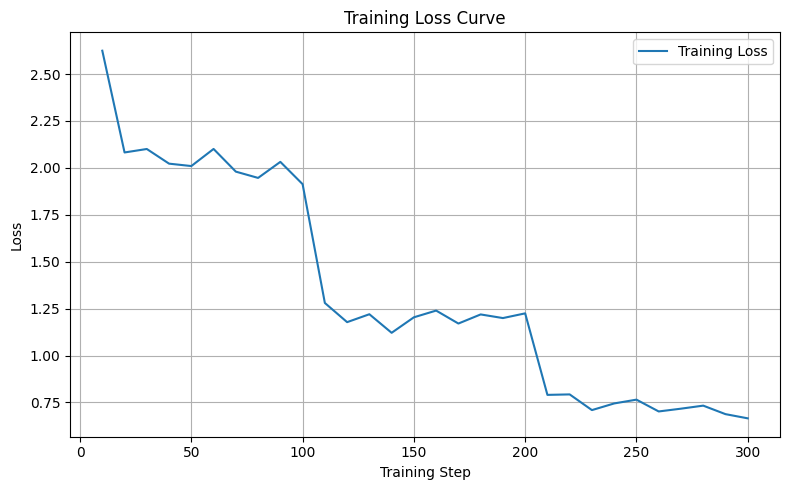

In [ ]:
train_loss = []
steps = []

for log in trainer.state.log_history:
    if "loss" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
        steps.append(log["step"])

# Plot della training loss
plt.figure(figsize=(8, 5))
plt.plot(steps, train_loss, label="Training Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# load tokenizers and model
tokenizer = AutoTokenizer.from_pretrained(OUT_PATH_GEMMA2B_FINETUNED)
model = AutoModelForCausalLM.from_pretrained(
    OUT_PATH_GEMMA2B_FINETUNED,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model.eval()

# test prompt
test_prompts = [
    "girl riding a horse\n##\n",
    "desert during midday\n##\n",
    "face of Cristiano Ronaldo\n##\n",
    "Sad News: The Church Of Pentecost Mourns As Their Top-Notch Pastor Has Been Reported Dead - Details Their Pastor: Pastor-of-Sad-make\n##\n"
]

# paramenter for generation
generation_kwargs = {
    "max_new_tokens": 50,
    "do_sample": True,
    "temperature": 2.0,
    "top_p": 0.9,
    "repetition_penalty": 0.98,
    "eos_token_id": None,
    "pad_token_id": tokenizer.eos_token_id
}

# generation for each prompt
for prompt in test_prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, **generation_kwargs)

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Eliminate \nEND
    stop_idx = decoded.find("\nEND")
    if stop_idx != -1:
        decoded = decoded[:stop_idx + len("\nEND")]

    print(f"Input:\n{prompt.strip()}")
    print(f"Generated:\n{decoded.split('##')[-1].strip()}")
    print("=" * 50)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Input:
girl riding a horse
##
Generated:
Replace the horse with a zebra
%%
girl riding a zebra
END
Input:
desert during midday
##
Generated:
during late afternoon
%%
desert during late afternoon
END
Input:
face of Cristiano Ronaldo
##
Generated:
move him to space
%%
face of Cristiano Ronaldo in space
END
Input:
Sad News: The Church Of Pentecost Mourns As Their Top-Notch Pastor Has Been Reported Dead - Details Their Pastor: Pastor-of-Sad-make
##
Generated:
use sad music
%%
Sad News: The Church Of Pentecost Mourns As Their Top-Notch Pastor Has Been Reported Dead - Play Sad Music - Details Their Pastor: Pastor-of-Sad-make
END


## Creation of dataset for ControlNet

In [ ]:
# Take only the first 1900 samples from visual-layer/imagenet-1k-vl-enriched

ds = load_dataset(DATASET_HF, split="train", streaming=True, revision="refs/convert/parquet")
prompts = []
for i, row in enumerate(ds):
    if i >= 1900:
        break
    prompts.append(row['caption_enriched'])

df = pd.DataFrame({'caption_enriched': prompts})
df.rename(columns={'caption_enriched': 'original_prompt'}, inplace=True)

df.to_json(OUT_PATH_DATASET_HF, orient="records", indent=2, force_ascii=False)

print(f"File saved as: {OUT_PATH_DATASET_HF}")


Resolving data files:   0%|          | 0/207 [00:00<?, ?it/s]

File saved as: /content/drive/MyDrive/Neural Networks/PROJECT/MODEL/OUT_COLAB/FROM_GEMMA_2B/FROM_HUGGING_FACE.json


In [ ]:
'''
  This code appends an additional 1,000 new samples, retrieved from
  the same Hugging Face dataset, to the previously constructed dataset,
  resulting in an expanded combined dataset
'''

START = 1900          # Start indix
N_NEW = 1000          # How many new samples need to be taken

ds = load_dataset(DATASET_HF, split="train", streaming=True, revision="refs/convert/parquet")

prompts = []
for i, row in enumerate(ds):
    if i < START:
        continue
    prompts.append(row["caption_enriched"])
    if len(prompts) >= N_NEW:
        break

new_df = pd.DataFrame({"original_prompt": prompts})

# Read JSON and concatenate
try:
    old_df = pd.read_json(OUT_PATH_DATASET_HF)
except FileNotFoundError:
    old_df = pd.DataFrame(columns=["original_prompt"])
except ValueError:
    old_df = pd.DataFrame(columns=["original_prompt"])

merged = pd.concat([old_df, new_df], ignore_index=True)
merged.to_json(OUT_PATH_DATASET_HF, orient="records", indent=2, force_ascii=False)

print(f"Added {len(new_df)} new samples. New TOTAL: {len(merged)}")


Resolving data files:   0%|          | 0/207 [00:00<?, ?it/s]

Added 1000 new samples. New TOTAL: 2900


In [ ]:
'''
  This code can be used in case you want a
  file with only new sample taken from
  hugging face
'''

START = 1900          # Start Index
COUNT = 1000          # How many new samples
STOP = START + COUNT

OUT_JSON = f"/content/drive/MyDrive/Neural Networks/PROJECT/MODEL/OUT_COLAB/FROM_GEMMA_2B/FROM_HUGGING_FACE_{START}_{STOP}.json"

ds = load_dataset(DATASET_HF, split="train", streaming=True, revision="refs/convert/parquet")

prompts = []
for i, row in enumerate(ds):
    if i < START:
        continue
    if i >= STOP:
        break
    prompts.append(row["caption_enriched"])

df = pd.DataFrame({"original_prompt": prompts})
df.to_json(OUT_JSON, orient="records", indent=2, force_ascii=False)

print(f"Saved {len(df)} samples in range {START}, {STOP}) to: {OUT_JSON}")


Resolving data files:   0%|          | 0/207 [00:00<?, ?it/s]

Saved 1000 samples in range [1900, 2900) to: /content/drive/MyDrive/Neural Networks/PROJECT/MODEL/OUT_COLAB/FROM_GEMMA_2B/FROM_HUGGING_FACE_1900_2900.json


In [ ]:
"""
  This code use the finetuned model
  for generate dataset for ControlNet
"""

# Load Tokenizers and model
tokenizer = AutoTokenizer.from_pretrained(OUT_PATH_GEMMA2B_FINETUNED)
stop_sequence_ids = tokenizer.encode(STOP, add_special_tokens=False)

model = AutoModelForCausalLM.from_pretrained(
    OUT_PATH_GEMMA2B_FINETUNED,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model.eval()

# Paramenters for Generation
generation_kwargs = {
    "max_new_tokens": 80,
    "do_sample": True,
    "temperature": 2.0,
    "top_p": 0.9,
    "repetition_penalty": 0.98,
    "pad_token_id": tokenizer.eos_token_id,
    "eos_token_id": None
}

# Load Orginal_Prompt
df = pd.read_json(OUT_PATH_DATASET_HF)
def pick_prompt(x):
    if isinstance(x, dict):
        return x.get("prompt", "")
    return str(x) if x is not None else ""

original_prompts = (df["original_prompt"].dropna().map(pick_prompt).astype(str).tolist()[:MAX_SAMPLES])

# Function for generation
def generate_edit_and_output(original_prompt):
    prompt = original_prompt.strip() + "\n##\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, **generation_kwargs)

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    try:
        content = decoded.split("\n##\n", 1)[1]
        edit_prompt, output_prompt = content.split("\n%%\n", 1)
        output_prompt = output_prompt.split(STOP)[0].strip()
        return edit_prompt.strip(), output_prompt.strip()
    except Exception as e:
        return None, None

# Generation with ceckpoint
triplets = []

for i, prompt in enumerate(tqdm(original_prompts, desc="Generating edit/output prompts")):
    edit, output = generate_edit_and_output(prompt)
    if edit and output:
        triplets.append({
            "original_prompt": prompt,
            "edit_prompt": edit,
            "edited_prompt": output
        })

    if (i + 1) % SAVE_EVERY == 0 or (i + 1) == MAX_SAMPLES:
        temp_df = pd.DataFrame(triplets)
        with open(OUT_PATH_DATASET_GENERATED_JSONL, "a", encoding="utf-8") as f_json:
            for ex in triplets:
                f_json.write(f"{json.dumps(ex)}\n")

        temp_df.to_csv(OUT_PATH_DATASET_GENERATED_CSV, mode="a", index=False, header=not os.path.exists(OUT_PATH_DATASET_GENERATED_CSV))
        print(f"\n Saved {i+1} samples")
        triplets = []  # reset buffer

print("Dataset created")


# Clean Data

In [ ]:
def remove_duplicates(file_path, column1, column2):
  df = pd.read_json(file_path, lines=True)
  print(f"number of rows BEFORE {len(df)}")
  filtered_df = df[df[column1] != df[column2]]
  print(f"number of rows AFTER {len(df)}")
  filtered_df.to_json(file_path, orient="records", lines=True, force_ascii=False)

In [ ]:
def clean(x):
    if not isinstance(x, str):
        return x
    x = x.replace("\r\n", " ").replace("\n", " ").replace("\r", " ")
    x = " ".join(x.split())
    return x

In [ ]:
df = pd.read_json(OUT_PATH_DATASET_GENERATED_JSONL, lines=True)
df["original_prompt"] = df["original_prompt"].map(clean)
df.to_json(OUT_PATH_DATASET_GENERATED_JSONL_CLEANED, orient="records", lines=True, force_ascii=False)
print(f"File cleaned saved in: {OUT_PATH_DATASET_GENERATED_JSONL_CLEANED}")


File cleaned saved in: /content/drive/MyDrive/Neural Networks/PROJECT/MODEL/OUT_COLAB/FROM_GEMMA_2B/triplets_generated_clean.jsonl


In [ ]:
# Convert golden_dataset from .json .jsonl
from_json_to_jsonl(GOLDEN_SAMPLES_JSON, GOLDEN_SAMPLES_JSONL)

# Change name columns
#change_name_columns(OUT_PATH_DATASET_GENERATED_JSONL, "output_prompt", "edited_prompt")

# Remove original_prompt = edited_prompt
remove_duplicates(OUT_PATH_DATASET_GENERATED_JSONL, "original_prompt", "edited_prompt")

# Add golden label to generated file
concat_jsonl(GOLDEN_SAMPLES_JSONL, OUT_PATH_DATASET_GENERATED_JSONL, OUT_PATH_FINAL_DATA)

CONVERSION DONE and file saved in: /content/drive/MyDrive/Neural Networks/PROJECT/DATASET/golden_label.jsonl
number of rows BEFORE 1900
number of rows AFTER 1900
ROWS: 2000
